# 엔드 투 엔드 예제: 고양이 vs 개 데이터세트에서 이미지 분류 모델 미세 조정
- 구체적인 엔드 투 엔드 전이 학습 및 fine-tuning 예제: ImageNet에서 사전 훈련된 Xception 모델을 로드하고 Kaggle "cats vs. dogs" 분류 데이터세트 사용
- [참고-텐서플로우](https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/guide/keras/transfer_learning.ipynb?hl=ko#scrollTo=852447087ba9)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/데이터/텐서플로우

/content/drive/MyDrive/데이터/텐서플로우


## 데이터 준비

In [4]:
import os
import zipfile

# 개 고양이 이미지 자료 다운로드
!wget --no-check-certificate \
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \-O  ./tmp/cats_and_dogs_filtered.zip

--2021-10-13 04:18:45--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.215.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./tmp/cats_and_dogs_filtered.zip’

./tmp/cats_and_dogs 100%[===================>]  65.43M  42.2MB/s    in 1.6s    

2021-10-13 04:18:47 (42.2 MB/s) - ‘./tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [5]:
# 현재작업폴더 하위의 tmp폴더에 있는 zip 파일 압축해제
local_zip = './tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./tmp')
zip_ref.close()

print('--end---')

--end---


In [6]:
# 작업경로 설정

#-----------기본경로
base_dir = './tmp/cats_and_dogs_filtered'

# 기본경로+폴더명 작성  (폴더명을 os.listdir 로 가져와서 작업해도 됨)
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

train_cats_dir = os.path.join(train_dir,'cats')
train_dogs_dir = os.path.join(train_dir,'dogs')

validation_cats_dir = os.path.join(validation_dir,'cats')
validation_dogs_dir = os.path.join(validation_dir,'dogs')

print('end')

end


In [7]:
train_cats_dir

'./tmp/cats_and_dogs_filtered/train/cats'

In [9]:
os.listdir(train_cats_dir)[:10]

['cat.127.jpg',
 'cat.126.jpg',
 'cat.125.jpg',
 'cat.124.jpg',
 'cat.123.jpg',
 'cat.122.jpg',
 'cat.121.jpg',
 'cat.120.jpg',
 'cat.119.jpg',
 'cat.118.jpg']

In [28]:
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)
test_cats_fnames = os.listdir(validation_cats_dir)
test_dogs_fnames = os.listdir(validation_dogs_dir)

In [29]:
# train데이터의 고양이와 강아지의 사진수
print(len(train_cats_fnames), len(train_dogs_fnames)) # 두 개의 데이터 수가 같으므로 편향이 없는 데이터이다.
# test데이터의 고양이와 강아지 사진수
print(len(test_cats_fnames), len(test_dogs_fnames))

1000 1000
500 500


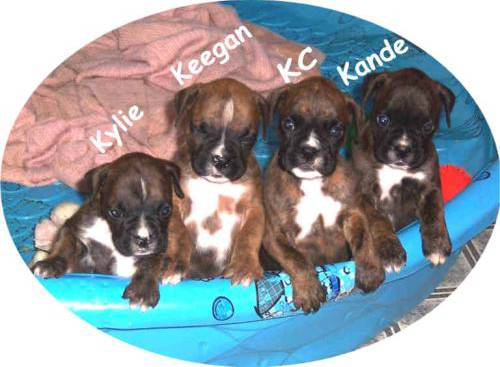

In [91]:
from PIL import Image

# 샘플사진
Image.open(train_dogs_dir+'/'+train_dogs_fnames[203])

## 이미지 제너레이터를 이용한 스케일링

In [30]:
# 텐서플로우의 이미지 제너레이터를 이용하여 데이터를 스케일링 함
# 이 작업에서는 사진의 회전, 확대 등 증강 기술들이 적용됨.

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255) # 255로 나눠 스케일링 함
test_datagen = ImageDataGenerator(rescale=1./255)

In [32]:
# 훈련과 테스트 자료를 폴더단위로 배치만큼만 읽으면서 x,y값의 형태를 제작
# 폴더안의 파일단위로 array를 append하고 폴더가 바뀌면 리스트를 추가해서 다시 append
# 2개의 폴더가 있어서 (2,20,150,150,3)

train_generator = train_datagen.flow_from_directory(train_dir, # target directory
                                                    batch_size=20,
                                                    target_size=(150,150),
                                                    class_mode='binary')
test_generator = test_datagen.flow_from_directory(validation_dir,
                                                    batch_size=20,
                                                    target_size=(150,150),
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [49]:
print(len(train_generator)) # 트레이닝 전체자료는 1000+1000개 = 2000개임. 그 중 배치를 20으로 했으니까 2000/20=100개
print(len(test_generator)) # 1000/20 = 50개

100
50


In [47]:
import numpy as np
print(np.shape(train_generator[0][0])) # 20장의 사진
print(np.shape(train_generator[0][0][0])) # 20장의 사진 중 첫번째 사진 

(20, 150, 150, 3)
(150, 150, 3)


In [110]:
print(len(train_generator[1])) # 2는 이미지 자료를 갖고있는 array와 레이블 정보를 갖고있는 array 2개 있음.

# 사진 이미지 pixcel값
print(len(train_generator[0][0])) # 20개의 이미지 값
# train_generator[0][0][0], train_generator[0][0][1], train_generator[0][0][2]

# 개, 고양이 레이블값
print(train_generator[0][1]) # cat은 0, dog는 1로 고양이와 개의 bool값

print(len(train_generator)) # 배치 단위 개수

# train_generator[0], train_generator[1], train_generator[2], ..., train_generator[99] 해서 100개의 배치자료가 있음.
# train_generator[0][0][0] => 0번째 배치(0~19번째 사진)의 사진 중 사진이미지를 갖고있는 array의 첫번째 사진
# train_generator[0][1][0] => 0번째 배치(0~19번째 사진)의 사진 중 첫번째 레이블값
# train_generator[1][0][0] => 1번째 배치(20~39번째 사진)의 사진 중 사진이미지를 갖고있는 array의 첫번째 사진

2
20
[1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0.]
100


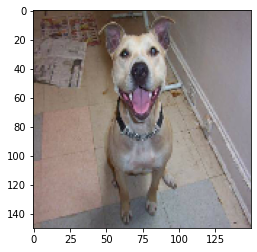

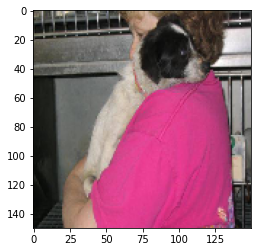

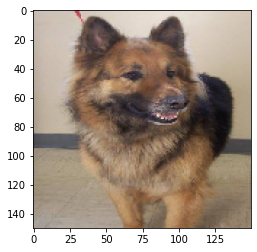

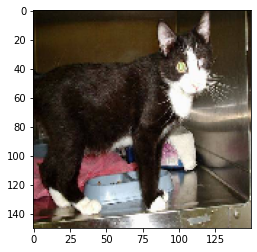

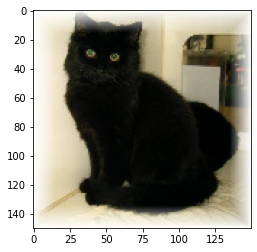

In [50]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.imshow(train_generator[0][0][i])
    plt.show()

## 모델 구성하기

- Param, Output Shape 계산해보기

In [72]:
# 모델 구축
# ----- Param 계산 공식------
# 첫번째 Param 계산 공식 : (필터*필터*input수(채널수)*유닛수) + 바이어스수(=유닛수)
# 두번째부터 Param 계산 공식 : (필터*필터*앞의 유닛수*유닛수) + 바이어스수(=유닛수)

# ----- Output Shape 계산공식 -----
# (input의 shape수 - 필터 길이 + 2*패딩수) / 스트라이드수 + 1
# 첫번째 model.add (150-3+2*0)/1+1

from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), # 필터: 무작위의 값을 갖는 3*3의 9개의 픽셀, 9개의 픽셀이 이미지의 각 픽셀과 곱셈 
                                # => 즉, 3*3필터가 3개의 채널을 모두 계산해야 함. w값이 (3*3)*3*32+32 = 896개의 Param
                        activation='relu', input_shape=(150,150,3)))
# model.add(layer.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation='relu')) # (3*3*32*64)+64
model.add(layers.Conv2D(128,(3,3), activation='relu')) # (3*3*64*128)+128

In [73]:
3*3*64*128+128

73856

In [74]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 144, 144, 128)     73856     
Total params: 93,248
Trainable params: 93,248
Non-trainable params: 0
_________________________________________________________________


- 모델 구성

In [75]:
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))   
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())   # 7*7*128=6272
model.add(layers.Dense(512, activation='relu'))  
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## 모델 학습

In [76]:
# 이미지 제너레이터 자료는 모델 fit할 때 입력하는 훈련자료와 테스트 자료에 사용
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100, 
      epochs=30,
      validation_data=test_generator,
      validation_steps=50)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 [==============================] - 118s 1s/step - loss: 0.6924 - acc: 0.5365 - val_loss: 0.6758 - val_acc: 0.6190
Epoch 2/30
100/100 [==============================] - 115s 1s/step - loss: 0.6624 - acc: 0.6095 - val_loss: 0.6444 - val_acc: 0.6000
Epoch 3/30
100/100 [==============================] - 115s 1s/step - loss: 0.6135 - acc: 0.6650 - val_loss: 0.6309 - val_acc: 0.6140
Epoch 4/30
100/100 [==============================] - 115s 1s/step - loss: 0.5597 - acc: 0.7200 - val_loss: 0.5719 - val_acc: 0.6990
Epoch 5/30
100/100 [==============================] - 116s 1s/step - loss: 0.5336 - acc: 0.7260 - val_loss: 0.6199 - val_acc: 0.6630
Epoch 6/30
100/100 [==============================] - 116s 1s/step - loss: 0.5047 - acc: 0.7475 - val_loss: 0.5495 - val_acc: 0.7190
Epoch 7/30
100/100 [==============================] - 115s 1s/step - loss: 0.4739 - acc: 0.7690 - val_loss: 0.5468 - val_acc: 0.7230
Epoch 8/30
100/100 [==============================] - 115s 1s/step - 

## 학습 과정 시각화

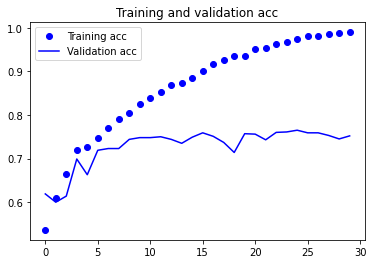

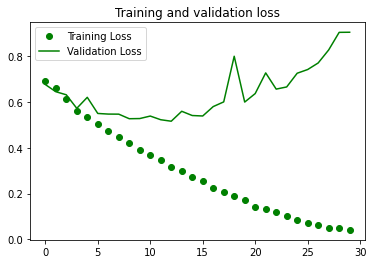

In [77]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [79]:
# 모델 저장
model.save('dog_cat.h5')